In [ ]:
%pip install face-alignment

# Import libraries

In [ ]:
import cv2 as cv
import math
from face_alignment import FaceAlignment
from face_alignment import LandmarksType
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from PIL import Image
import os
import torch
from torchvision.transforms import functional as TF
import torchvision.transforms as transforms

## Data analysis

- Show the number of frames contained in each sequence

- Show the sequence frames along with the Prkachin and Solomon Pain Intensity (PSPI) score of each frame in a graph

- Show the number of the sequence that are labeled as no pain, medium pain and severe pain in a histogram




In [9]:
import os
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [10]:
data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"

if os.path.exists(data_root):
    print("Path is found.",sep=' ', end=' ', flush=True)
    if os.scandir(data_root):
        print("Folder is not empty.")


Path is found. Folder is not empty.


In [11]:
# Define the directory where your data is stored
img_dir = os.path.join(data_root, "Images")
images = os.listdir(img_dir)


The total count of the PSPI from 0 - 10


In [12]:
PSPI_label = data_root + '\\Frame_Labels\\PSPI'

label_count = {}

for subject in os.listdir(PSPI_label):
    for sequence in os.listdir(os.path.join(PSPI_label, subject)):
        for label in os.listdir(os.path.join(PSPI_label,subject, sequence)):
            with open(os.path.join(PSPI_label,subject, sequence, label), 'r') as label_file:
                vas = int(float(label_file.read().strip()))
                if label_count.get(vas) is None:
                    label_count[vas] = 1
                else:
                    temp = label_count.get(vas)
                    #update count value
                    label_count[vas] += 1

print(label_count)


{0: 40029, 1: 2909, 2: 2351, 4: 802, 5: 242, 6: 270, 3: 1412, 7: 53, 8: 79, 9: 32, 10: 67, 11: 76, 12: 48, 13: 22, 14: 1, 15: 5}


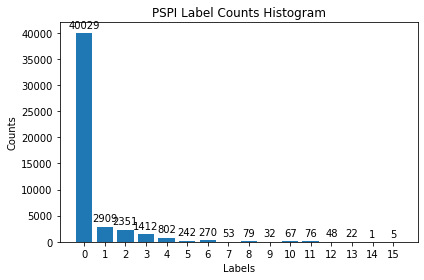

In [16]:
# Extract labels and counts from the dictionary
sorted_label_counts = dict(sorted(label_count.items()))

labels = list(sorted_label_counts.keys())
counts = list(sorted_label_counts.values())

# Create a bar plot (histogram)
plt.bar(labels, counts,tick_label=labels)

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('PSPI Label Counts Histogram')

# # Display the plot
plt.tight_layout()

for x, y in zip(labels, counts):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()


Frames vs PSPI Score

In [7]:
from matplotlib.layout_engine import ConstrainedLayoutEngine
def print_img_PSPI(img_dir, subject, sequence):
    image_filenames = []
    pain_intensity_labels = []
    average_intensity_scores = []

    sequence_dir = os.path.join(img_dir, subject , sequence)
    image_label_dir = os.path.join(data_root, "Frame_Labels","PSPI", subject, sequence)

    for filename in sorted(os.listdir(sequence_dir)):
        if filename.endswith('.png'):  # Adjust the file extension as needed
            # Load the image
            img = cv2.imread(os.path.join(sequence_dir, filename))
            image_filenames.append(img)

            # Load the pain intensity label from the corresponding text file
            label_filename = os.path.splitext(filename)[0] + '_facs.txt'

            with open(os.path.join(image_label_dir, label_filename), 'r') as label_file:
                pain_intensity = int(float(label_file.read().strip()))
                pain_intensity_labels.append(pain_intensity)

   # Calculate average intensity scores for each batch (for demonstration purposes)
    num_batches = 15
    batch_size = len(image_filenames) // num_batches


    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size


        # Calculate the average intensity score for the current batch
        average_intensity = np.mean(pain_intensity_labels[start_index:end_index])
        average_intensity_scores.append(pain_intensity_labels[start_index])

    # Create a smooth curve fitted graph
    x = np.arange(0, num_batches)
    y = average_intensity_scores

    # Use make_interp_spline for a smooth curve fit
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    fig = plt.figure(figsize=(16, 10),constrained_layout= True)

    gs1 = fig.add_gridspec(2, num_batches,height_ratios=[1,3])

    # Create subplots for the images in the first row
    for i in range(num_batches):
        ax = fig.add_subplot(gs1[0, i])
        ax.imshow(cv2.cvtColor(image_filenames[i * batch_size], cv2.COLOR_BGR2RGB))
        ax.axis('off')

    # Plot the smooth curve in the second row
    ax = fig.add_subplot(gs1[1, :num_batches])
    ax.plot(x_smooth, y_smooth, label='Smooth Curve', linewidth=2)
    ax.scatter(x, y, color='red', marker='o', label='Data Points')
    ax.set_xlabel('Batch Index')
    ax.set_ylabel('Average Pain Intensity')
    ax.set_title('Smooth Curve Fitted Graph - ' + sequence)
    ax.legend()
    ax.grid(True)

    plt.show()



In [ ]:
# Initialize lists to store image filenames and pain intensity labels
for subject in images:
    for sequence in os.listdir(img_dir+'/'+subject):
        print_img_PSPI(img_dir, subject, sequence)

    break


## Preprocess the data
- enhance the appearance of the face
- align the face
- crop the face

In [ ]:
from tqdm import trange, tqdm_notebook
from time import sleep 

class preprocess():

    def __init__(self, frames, subject_code, sequence_code):
        super(preprocess, self).__init__()
        self.frames = frames
        self.subject_code = subject_code
        self.sequence_code = sequence_code
        # Do landmark detection on the input frames for face recognition proposes
        # self.landmarkDetection()

        self.readLandmarkLabel()

        # Mask the non-face area with black pixels
        self.frames = self.maskFace()

        # Tilt and align the face at centre, then crop the frames according to the face region
        self.frames = self.tiltAlign()

        self.frames = self.resize_frames()

        self.savePreprocessedimages()

    def resize_frames(self):
        frames = []

        for img in self.frames:
            img = cv.resize(img, (240,240))
            frames.append(img)

        return frames
    def savePreprocessedimages(self):
        print("Saving...")
        path = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\Preprocessed"
        target_dir =""
        # check filepath exist
        if not os.path.exists(path):
            print("checking root...")
            os.mkdir(path)
            
        subject_path = os.path.join(path, self.subject_code)

        if not os.path.exists(subject_path):
            print("checking subject folder")
            os.mkdir(subject_path)

        sequence_path = os.path.join(subject_path, self.sequence_code)

        if not os.path.exists(sequence_path):
            print("checking sequence path")
            os.mkdir(sequence_path)
            target_dir = sequence_path

        print(target_dir)
        for i in trange((len(self.frames)), desc="Saving_" +self.sequence_code ):
            n = f'{i+1:03}'
            cv.imwrite(f'{target_dir}\{self.sequence_code}{n}.png', cv.cvtColor(self.frames[i], cv.COLOR_BGR2RGB))
            sleep(0.01)

    def readLandmarkLabel(self):
        label_path = os.path.join(data_root, "AAM_landmarks", self.subject_code, self.sequence_code)
        all_frames_landmark = []
        frames = self.frames
        n=0
        for frames_label in os.listdir(label_path):
            
            landmarks = []
            landmarks_tuple = []

            img = (frames[n])
            img = img.copy()
            
            if frames_label.endswith(".txt"):
                landmark_file_path = os.path.join(label_path, frames_label)

                with open(landmark_file_path,  'r') as file:
                    landmarks = [list(map(float, line.strip().split())) for line in file]

            if landmarks is not None:
                # Iterate over the detected faces
                for pred in landmarks:
                    
                    x, y = pred
                    landmarks_tuple.append((int(x), int(y)))
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)
            all_frames_landmark.append(landmarks_tuple)
            n += 1

        self.framesLandmark=all_frames_landmark

    def delete_files_in_directory(self, directory_path):
        try:
            with os.scandir(directory_path) as entries:
                for entry in entries:
                    if entry.is_file():
                        os.unlink(entry.path)
                print("All files deleted successfully.")
        except OSError:
            print("Error occurred while deleting files.")

    def landmarkDetection(self):
        print("Detecting landmark...")
        frames = self.frames
        output = []
        framesLandmark = []
        model = FaceAlignment(landmarks_type=LandmarksType.TWO_D, face_detector='blazeface',
                              face_detector_kwargs={'back_model': True}, device='cpu')
        
        for n in trange(len(frames), desc="Detecting landmark_" + self.sequence_code):
            img = (frames[n])
            img = img.copy()
            landmarks = model.get_landmarks(img)
            landmarks_tuple = []
            if landmarks is not None:
                # Iterate over the detected faces
                for pred in landmarks:
                    # Draw landmarks on the frame
                    for point in pred:
                        x, y = point
                        landmarks_tuple.append((int(x), int(y)))
                        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                            cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

            framesLandmark.append(landmarks_tuple)
            output.append(img)
            sleep(0.01)

        self.framesLandmark = framesLandmark

    def tiltAlign(self):
        print("Tilting and aligning...")
        frames = self.frames
        output =[]
        for i in trange(len(frames), desc = "Tilt_align_" + self.sequence_code):
            
            img = frames[i]
            landmarkTuple = self.framesLandmark[i]
            # Landmark index of reight eye and left eye are
            right_eye_cood = [(landmarkTuple[39][0] + landmarkTuple[36][0])/2, (landmarkTuple[39][1] + landmarkTuple[36][1])/2]
            left_eye_cood = [(landmarkTuple[45][0] + landmarkTuple[42][0])/2, (landmarkTuple[45][1] + landmarkTuple[42][1])/2]
            x1, y1 = right_eye_cood
            x2, y2 = left_eye_cood

            a = abs(y1 - y2)
            b = abs(x2 - x1)
            c = math.sqrt(a * a + b * b)

            cos_alpha = (b * b + c * c - a * a) / (2 * b * c)

            alpha = np.arccos(cos_alpha)
            alpha = (alpha * 180) / math.pi
            img = Image.fromarray(img)
            if y1>y2 :
                alpha = -alpha
            img = np.array(img.rotate(alpha))
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            output.append(img)
            
            sleep(0.01)
        return output

    def maskFace(self):
        print("Masking...")
        routes = [i for i in range (16,-1,-1)] + [i for i in range (17,26+1)]

        frames = self.frames
        output = []
        for n in trange(len(frames), desc = "Masking_" + self.sequence_code):
            
            routes_cod = []
            mask = None
            out = None
            landmarks_tuple = self.framesLandmark[n]
            img = (frames[n])
            img = img.copy()
            img2 = img.copy()
            for i in range (0, len(routes)-1):
                source_point = routes[i]
                target_point = routes[i+1]

                source_cod = landmarks_tuple[source_point]
                target_cod = landmarks_tuple[target_point]
                routes_cod.append(source_cod)
                cv.line(img, (source_cod), (target_cod),(255,255,255),2)

            routes_cod = routes_cod+[routes_cod[0]]

            mask = np.zeros((img.shape[0], img.shape[1]))
            mask = cv.fillConvexPoly(mask, np.array(routes_cod),1)
            mask = mask.astype(np.bool_)
            out = np.zeros_like(img)
            out[mask] = img2[mask]
            # plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
            output.append(cv.cvtColor(self.cropFaceArea(out, mask), cv.COLOR_BGR2RGB))
            
            sleep(0.01)
        return output

    def cropFaceArea(self, frame, mask):

        gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
        contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        # Get the bounding box of the largest contour

        largest_contour = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest_contour)

        # Crop the image to the size of the masked face
        cropped_image = frame[y:y+h, x:x+w]

        return cropped_image

    def padding_normalization(self, target_length):
        print("padding and normalising...")
        """
        Preprocesses a sequence of images and pads them to a target length.

        Args:
            images (list): List of PIL images.
            target_length (int): Desired length of the sequence after padding.

        Returns:
            torch.Tensor: Tensor of preprocessed and padded images.
        """
        # Resize the images to a consistent size
        array_images = self.frames
        images =[]

        for image in array_images:
            images.append((Image.fromarray(image)))

        resized_images = [TF.resize((img), [224, 224]) for img in images]

        # Convert the images to tensors
        tensor_images = [TF.to_tensor(img) for img in resized_images]

        # Stack the tensor images along a new dimension (sequence dimension)
        tensor_sequence = torch.stack(tensor_images)

        # Calculate the current length of the sequence
        current_length = tensor_sequence.size(0)

        # Pad the sequence if necessary
        if current_length < target_length:
            padding_length = target_length - current_length
            padding = torch.zeros(padding_length, *tensor_sequence.shape[1:])
            tensor_sequence = torch.cat((tensor_sequence, padding))

        # Normalize the tensor sequence
        # Define the mean and standard deviation values for normalization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Apply normalization to the tensor sequence
        normalize = transforms.Normalize(mean=mean, std=std)
        normalized_sequence = normalize(tensor_sequence)

        return normalized_sequence



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
from tqdm.notebook import trange, tqdm

from time import sleep 

# Load the images into a array
# The structure of the dataset folder
# root > Images > Subject > Sequences > *frame
data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_dir = os.path.join(data_root, "images")

images_data_dir = img_dir # Path that contains all the subject frames of sequences
labels_dir = os.path.join(data_root, 'Sequence_Labels', "VAS")

# Create lists to store preprocessed images and labels
preprocessed_images = []
preprocessed_labels = []

image_subject = os.listdir(images_data_dir)

# Iterate through subject folders (assuming subject folders are labeled with integers)
for i in trange(len(image_subject), desc = "Preprocess progress" ) :
    subject_folder = image_subject[i]
    subject_path = os.path.join(images_data_dir, subject_folder)

    # Skip non-directory files
    if not os.path.isdir(subject_path):
        continue

    # Iterate through sequence folders
    all_sequence_list = os.listdir(subject_path)
    for i in trange(len(all_sequence_list), desc = "Subject_"+subject_folder):
        
        sequence_folder = all_sequence_list[i]
        if os.path.exists(os.path.join("D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\Preprocessed",
                                       subject_folder, sequence_folder)):
            continue
        sequence_path = os.path.join(subject_path, sequence_folder)

        # Initialize a list to store image frames in the current sequence
        sequence_images = []

        # Skip non-directory files
        if not os.path.isdir(sequence_path):
            continue
        
        allframes_path = sorted(os.listdir(sequence_path))

        # Iterate through frames in the sequence
        for i in trange(len(allframes_path),desc='Reading Images_'+sequence_folder):
            frame_filename = allframes_path[i]

            if not frame_filename.endswith('.png'):
                continue

            frame_path = os.path.join(sequence_path, frame_filename)

            # Load the image
            img = cv2.imread(frame_path)

            # Append the image to the images list
            sequence_images.append(img)
            sleep(0.01)


        preprocessing = preprocess(sequence_images, subject_folder, sequence_folder)
       
        sleep(0.01)
    sleep(0.01)

        

# Convert the lists of preprocessed images and labels to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
preprocessed_labels = np.array(preprocessed_labels)


# Data Loading

### Load data and do subset for the data 

Select the frames from 48k images where consist of the PSPI from 0 to 10 (PSPI >10 is considered as 10) 

The data should be selected evenly from 25 subject, and each class should have 400 frames for each classes 

Total number of frames for each class
{0: 40029, 1: 2909, 2: 2351, 4: 802, 5: 242, 6: 270, 3: 1412, 7: 53, 8: 79, 9: 32, 10: 67, 11: 76, 12: 48, 13: 22, 14: 1, 15: 5}

There will be total of 4000 images consist in the dataset

Relation between the VAS and PSPI, use this as reference to classify the PSPI to 5 differenct classes
https://www.researchgate.net/publication/297637563_Supplemental_Material_Automatic_Pain_Assessment_with_Facial_Activity_Descriptors 

{PSPI: 0: No Pain; 
1: Mild Pain (VAS: 1-2); 
2-3: Moderate (VAS: 5-3);
4: Very Pain (VAS: 6-7);
\>=5: Severe Pain (VAS: 8-10)}

Proposed size of dataset is 6000 images 
each class should contains 1200 images



In [ ]:
import os 

def get_subject_list():
	dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
	img_folder_dir = os.path.join(dataset_root, "Images")
	return list(os.listdir(img_folder_dir))

In [ ]:
import os 

dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_folder_dir = os.path.join(dataset_root, "Images")
PSPI_folder_dir = os.path.join(dataset_root, "Frame_Labels", "PSPI")

# Get all subject 
all_subject = get_subject_list

In [ ]:
from time import sleep
from tqdm.notebook import trange
import os 
subset_image_dir = {}
subset_label= {}
class_count = {x:0 for x in range(5)}
read_file = {}

dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_folder_dir = os.path.join(dataset_root, "Images")
PSPI_folder_dir = os.path.join(dataset_root, "Frame_Labels", "PSPI")
subject_id = os.listdir(img_folder_dir)
classID = 0

while True:
	count = class_count.get(classID)
	for subject in subject_id:
		temp = {}
		PSPI_sequence_dir = os.path.join(PSPI_folder_dir, subject)
		i = 0
		for sequence_id in os.listdir(PSPI_sequence_dir):
			PSPI_sequence_id_folder = os.path.join(PSPI_sequence_dir, sequence_id)
			temp_img_dir_list =[]
			temp_label_list = []
			for frames in os.listdir(PSPI_sequence_id_folder):
				if i<=48 and count<=1200:
					pain_intensity = 0
					with open(os.path.join(PSPI_sequence_id_folder, frames), 'r') as label_file:
						pain_intensity = int(float(label_file.read().strip()))
					
					append_flag = read_file.get(os.path.join(PSPI_sequence_id_folder, frames))
					if ((pain_intensity <=1 and classID == pain_intensity) or (pain_intensity == 4 and classID == 3)) and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
					elif (pain_intensity==2 or pain_intensity==3) and classID==2 and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
					elif pain_intensity>=5 and classID == 4 and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
				else:
					break
			if subset_image_dir.get(subject) is None:
				subset_image_dir[subject] = temp_img_dir_list
				subset_label[subject] = temp_label_list
			else:
				update_img_list = subset_image_dir.get(subject)
				update_img_list.extend(temp_img_dir_list)
				subset_image_dir.update({subject:(update_img_list)})

				update_label_list = subset_label.get(subject)
				update_label_list.extend(temp_label_list)
				subset_label.update({subject:(update_label_list)})
			if i == 49 or count>=1200:
				break
		

	if count<1200 and not count==class_count.get(classID):
		class_count.update({classID:count})
		print(class_count)
		print("continue")
		continue
	elif classID < 4 :
		class_count.update({classID:count})
		print(class_count)
		print("next")
		classID+=1
	else:
		break	

{0: 1201, 1: 0, 2: 0, 3: 0, 4: 0}
next
{0: 1201, 1: 838, 2: 0, 3: 0, 4: 0}
continue
{0: 1201, 1: 1201, 2: 0, 3: 0, 4: 0}
next
{0: 1201, 1: 1201, 2: 984, 3: 0, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 0, 4: 0}
next
{0: 1201, 1: 1201, 2: 1201, 3: 508, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 619, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 668, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 717, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 766, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 0}
next
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 550}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 788}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 895}
continue


Write the path of the image and respective label file into the csv file


In [ ]:
import csv
def write_subject(subject, data_list, label_list):
	with open('subset_list.csv', 'a', encoding='UTF8',newline='') as f:
		writer = csv.writer(f)
		for i in range(len(data_list)):
			writer.writerow([subject, (data_list[i].split("_")[0] + ".png").replace("Images","Preprocessed"), label_list[i]])

def reset_csv():
	with open('subset_list.csv', 'w', encoding='UTF8',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(["subject", "path", "label"])

Write lines 

In [ ]:
for subject in subset_image_dir.keys():
	write_subject(subject, subset_image_dir.get(subject), subset_label.get(subject))


Moves all the selected data into another subset folder

In [ ]:
import shutil
import csv

image_dest = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Images"
label_dest = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Labels"

with open ("subset_list.csv") as csv_file:
	csv_reader = csv.reader(csv_file, delimiter=',')
	next(csv_reader)

	for row in csv_reader:
		if not os.path.exists(os.path.join(image_dest, row[0])):
			os.mkdir(os.path.join(image_dest, row[0]))
			os.mkdir(os.path.join(label_dest, row[0]))

		shutil.copy(row[1], os.path.join(image_dest, row[0]))
		shutil.copy(row[2], os.path.join(label_dest, row[0]))



In [1]:
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from torchvision import transforms
from sklearn.metrics import accuracy_score

from tqdm.notebook import trange
from tqdm import tnrange
from time import sleep

data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Images"
label_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Labels"

def load_subject_data(subject_name):
    subject_dir = os.path.join(data_root,subject_name)
    frames = []  # Load frames from the subject's directory
    pain_intensity_labels = []  # Load corresponding labels
    all_frames = sorted(os.listdir(subject_dir))
    for i in trange(len(all_frames),desc='Subject level progress'):
        
        filename = all_frames[i]
        if filename.endswith(".png"):
            try:
                # Load the pain intensity label from the corresponding text file
                label_filename = os.path.splitext(filename)[0] + '_facs.txt'
                label_path = os.path.join(label_root, subject_name)
                with open(os.path.join(label_path, label_filename), 'r') as label_file:
                    pain_intensity = int(float(label_file.read().strip()))
                    pain_intensity_labels.append(10 if pain_intensity>10 else pain_intensity)

                # Load the image
                img = cv2.imread(os.path.join(subject_dir, filename))
                img = cv2.resize(img, (150,150))
                frames.append(img)
            except Exception as e:
                print(e)
            finally:
                sleep(0.01)
                continue

    return frames, pain_intensity_labels

To get the subject list in the subset of data

In [2]:
import csv 
def get_subject_list():
	
	subject = []
	with open ("subset_list.csv") as csv_file:
		csv_reader = csv.reader(csv_file, delimiter=',')
		next(csv_reader)

		for row in csv_reader:
			subject.append(row[0])
	
	
	return list(set(subject))

In [ ]:
import numpy as np 
from tqdm.notebook import tnrange
# Define empty variable to load Data
all_frames = []
all_labels = []
all_subjects = []
subject_directories = get_subject_list()

for i in tnrange(len(subject_directories),desc='progress'):
    subject_name = subject_directories[i]
    try:
        frames, labels = load_subject_data(subject_name)
    except Exception as e:
        print(e)
        continue        

    all_frames.extend(frames)
    all_labels.extend(labels)
    all_subjects.extend([i] * len(frames))  # Assign a unique identifier to each subject
    sleep(0.01)

all_frames = np.array(all_frames)
all_labels = np.array(all_labels)
all_subjects = np.array(all_subjects)

## Reset the class of the data 

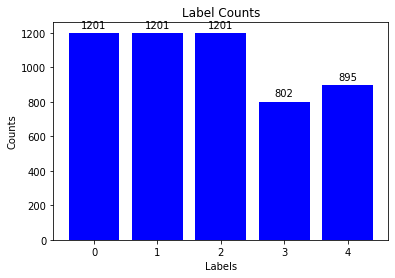

In [18]:
import pandas as pd
from matplotlib import pyplot as plt

# Relabel the class to be more balance 
new_class=[]
for n in range (len(all_labels)):
	temp = all_labels[n]
	if temp == 0: # No Pain
		new_class.append(0)
	elif temp == 1: # Mild Pain
		new_class.append(1)
	elif temp == 2 or temp == 3: # Moderate Pain 
		new_class.append(2)
	elif temp == 4: # Very Pain
		new_class.append(3)
	else: # PSPI >= 5 : Severe Pain
		new_class.append(4)

# Create a sample DataFrame
data = {'labels': new_class}
df = pd.DataFrame(data)

# Using value_counts() to count occurrences
label_counts = df['labels'].value_counts().to_dict()
# Create a bar chart
labels, counts = zip(*label_counts.items())
plt.bar(labels, counts, color='blue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Counts')
for x, y in zip(labels, counts):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Show the plot
plt.show()

Save the loaded data into pickel file

In [5]:
import pickle

# Save the variable to a new file
pickle.dump(all_frames, open('image.pkl', 'wb'))
pickle.dump(all_labels, open('label.pkl', 'wb'))
pickle.dump(all_subjects, open('subject.pkl', 'wb'))


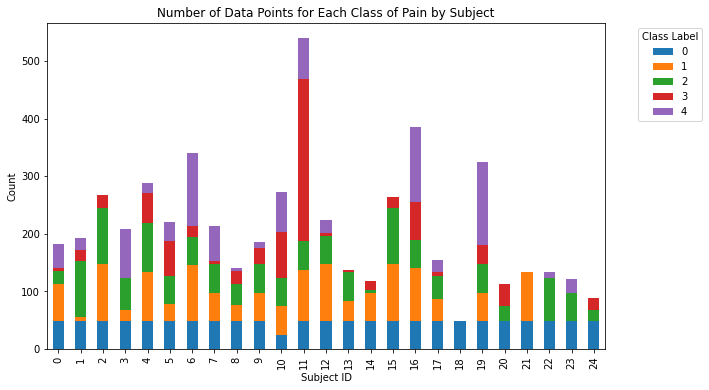

In [17]:
# analyse each subject contains how many types of classes
import pandas as pd
from matplotlib import pyplot as plt
# Sample DataFrame (replace this with your actual data)
data = {
    'Subject_ID': all_subjects,
    'Class_Label': new_class,
}

df = pd.DataFrame(data)

# Group by Subject_ID and Class_Label, and count the number of occurrences
subject_class_counts = df.groupby(['Subject_ID', 'Class_Label']).size().reset_index(name='Count')

# Display the result
pivot_df = subject_class_counts.pivot(index='Subject_ID', columns='Class_Label', values='Count').fillna(0)

# Plot the bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Data Points for Each Class of Pain by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Count')
plt.legend(title='Class Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
all_frames32 = np.array(all_frames, dtype=np.float32)
# Normalize the frames
all_frames_1 = all_frames32 / 255.0

Start training the model using a pretrained model VGG16 with the imagenet weight 

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.applications.vgg16 import VGG16
import efficientnet.keras as efn


class PainScorePredictor(tf.keras.Model):
    def __init__(self, dropout_rate=0.2):
        super(PainScorePredictor, self).__init__()

        self.conv1 = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(240,240, 3))
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.dropout1 = layers.Dropout(dropout_rate)

        self.conv2 = layers.Conv2D(256, (4, 4), strides=(1, 1), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.dropout2 = layers.Dropout(dropout_rate)

        self.conv3 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.dropout3 = layers.Dropout(dropout_rate)

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.dropout4 = layers.Dropout(dropout_rate)
        self.fc2 = layers.Dense(11)  # Assuming pain score is a scalar value

    def call(self, x):
        x = self.dropout1(self.pool1(self.conv1(x)))
        x = self.dropout2(self.pool2(self.conv2(x)))
        x = self.dropout3(self.pool3(self.conv3(x)))
        x = self.flatten(x)
        x = tf.nn.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


model = PainScorePredictor()
model.build((None, 120, 120, 3))
model.summary()


In [ ]:
# train by using pretrained model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

def initialise_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = (120,120, 3))

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


In [ ]:
'''
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(360, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.7)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(16, activation='softmax')(x)
'''

# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout


# x = base_model.output
# x = layers.Flatten()(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
# predictions = layers.Dense(16, activation="softmax")(x)

# model = tf.keras.models.Model(base_model.input, x)
# model = tf.keras.models.Model(base_model.input, predictions)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import ExponentialDecay

seed_value = 50
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# Assuming your data is loaded into X and y
# X: Features, y: Labels
X = all_frames_1
y = new_class

# Set up k-fold cross-validation
gkf = GroupKFold(n_splits=25)

# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(new_class), y=new_class)
class_weight_dict = dict(zip(np.unique(new_class), class_weights))
hist = []

# Initialize the learning rate decay method
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)

# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=all_subjects)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    # Apply SMOTE to oversample minority classes
    # smote = SMOTE(random_state=42)
    # X_resampled, y_resampled = smote.fit_resample(X_train.reshape(-1, (152*152*3)), y_train)

    # Compile and fit the model

    X_train = tf.convert_to_tensor(X_train)
    y_train = tf.convert_to_tensor(y_train)

    model = PainScorePredictor() #Use predefined model
    # model = initialise_IV3_model()

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule )  # Adjust the learning rate
    loss_function = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=30)

    hist.append(model.fit(X_train, y_train, class_weight=class_weight_dict, epochs=70, batch_size=5, 
                          validation_data=(X_val, y_val),callbacks=[early_stopping, PlotLearning()]))

    # hist.append(model.fit_generator(datagen.flow(X_train, y_train, batch_size=25),
    #                                 class_weight=class_weight_dict,
    #                                 steps_per_epoch= len(X_train) / 25,
    #                                 epochs=100,
    #                                 validation_data=(X_val, y_val),
    #                                 callbacks=[early_stopping, PlotLearning()]))

    # Evaluate on the test set or save the model for later use
    # test_loss, test_acc = model.evaluate(X_test, y_test)
    # print(f'Fold {fold + 1}: Test Accuracy: {test_acc * 100:.2f}%')


In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist[2].history["accuracy"])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Folds')
plt.show()